In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
from scipy.linalg import solve_discrete_are

Pendulum Physical Parameters

In [2]:
dt = 0.01 # timestep [s] 

# Mechanical Parameters
m1 = 0.1975 # motor stator pendulum arm mass
m2 = 0.2545 # motor rotor and reaction mass kg
L1 = 0.06   # pendulum Arm center of mass distance to axis
L2 = 0.088  # motor center of mass distance to axis
g = 9.81    # gravitational acceleration
R = 0.0655  # wheel radius

I1 = m1 * L1**2 / 12 # pendulum inertia with respect to CoG
I2 = m2 * R**2 / 2   # wheel inertia with respect to CoG

b_p = 0.007 # pendulum arm axis viscous friction
b_r = 0.0   # motor friction

# Motor Parameters
Vmax = 12 # maximal voltage
Ke = 0.29 # Motor EMF constant
Kt = 0.27 # Motor Torque constant

nom_torque = 0.21  # nominat torque
nom_vel = 35.9 # nominal velocity
b_r = nom_torque / nom_vel # motor viscous friction coefficient 

Rm = 22 # motor coil resistance
Lm = 0.01 # motor induction

Nonlinear model

In [3]:
# Build the model

a = m1 * L1**2 + m2 * L2**2 + I1
b = (m1*L1 + m2*L2)*g


def nonlinear_dynamics(theta, d_theta, phi, d_phi, voltage):
    # Input:
    #   theta - pendulum angle [rad]
    #   d_theta - pendulum angular velocity [rad/s]
    #   phi - wheel angle [rad]
    #   d_phi - wheel angular velocity [rad/s]
    
    _dd_theta = b*np.sin(theta)/a - b_p*d_theta/a + (Rm*b_r + Kt*Ke)*d_phi/(a*Rm) - (Kt*voltage)/(a*Rm)
    _dd_phi = -b*np.sin(theta)/a + b_p * d_theta / a - (a + I2)*(b_r + Kt*Ke/Rm)*d_phi/(I2 * a) - (a + I2) * Kt * voltage / (I2 * a * Rm)

    _theta = theta + d_theta * dt
    _d_theta = d_theta + _dd_theta * dt
    _phi = phi + d_phi * dt
    _d_phi = d_phi + _dd_phi * dt
    

    return np.array([_theta, _d_theta, _phi, _d_phi])

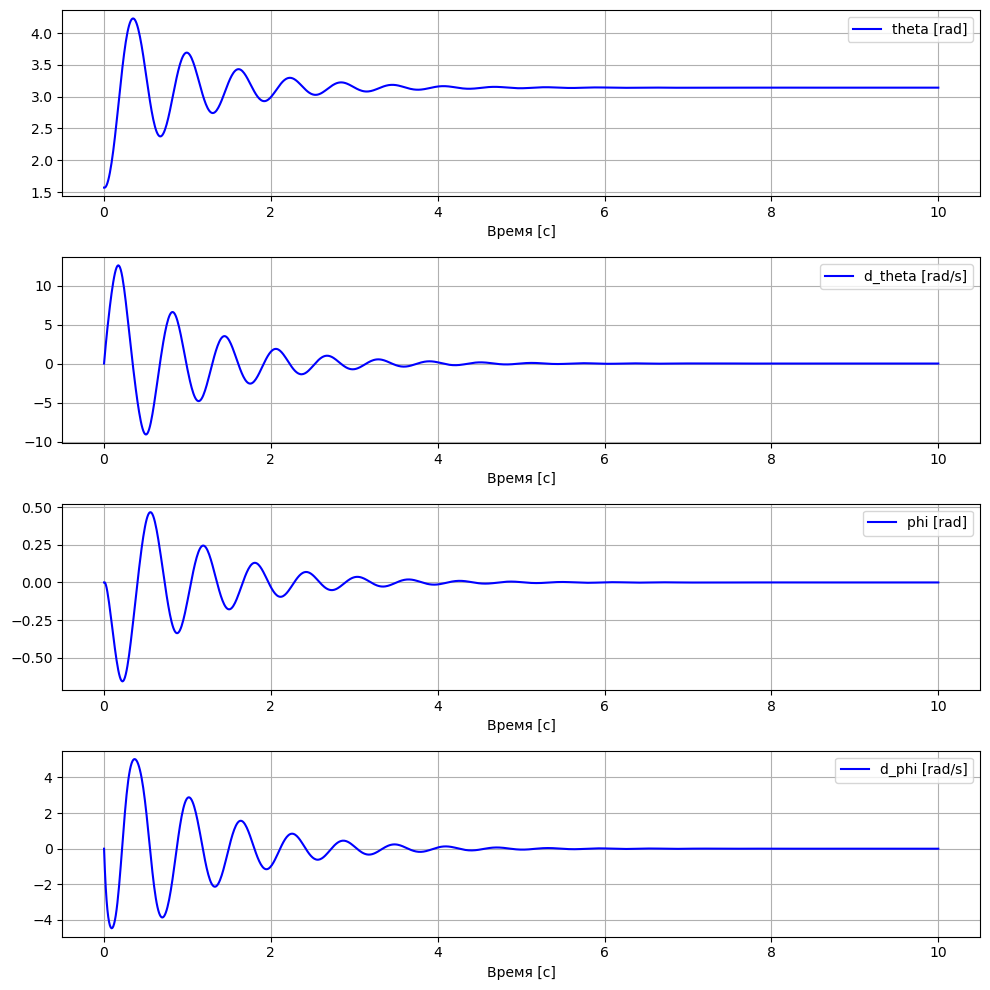

In [ ]:
# Simulate the model

t0 = 0 # start time [s] 
t1 = 10 # stop time [s] 

nt = int(t1/dt) + 1 # Number of points of sim time
T = np.linspace(t0, t1, nt)

x0 = np.array([1.57, 0, 0, 0]) #pend angle, pend angular vel, wheel angle, wheel ang vel
u = 0.0 # voltage [V]

X = [x0]
U = [u]

x_cur = x0.copy()

for t in T[:-1]:
    x_next = nonlinear_dynamics(x_cur[0], x_cur[1], x_cur[2], x_cur[3], u)

    X.append(x_next)
    U.append(u)

    x_cur = x_next.copy()

X = np.array(X)
U = np.array(U)
x1 = X[:, 0]
x2 = X[:, 1]
x3 = X[:, 2]
x4 = X[:, 3]


# Simulated data visualization 

plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1) 
plt.plot(T, x1, 'blue') 
plt.grid() 
plt.legend(labels=('theta [rad]',))
plt.xlabel("Время [с]")

plt.subplot(4, 1, 2) 
plt.plot(T, x2, 'blue') 
plt.grid() 
plt.legend(labels=('d_theta [rad/s]',))
plt.xlabel("Время [с]")

plt.subplot(4, 1, 3) 
plt.plot(T, x3, 'blue') 
plt.grid() 
plt.legend(labels=('phi [rad]',))
plt.xlabel("Время [с]")

plt.subplot(4, 1, 4) 
plt.plot(T, x4, 'blue') 
plt.grid() 
plt.legend(labels=('d_phi [rad/s]',))
plt.xlabel("Время [с]")


plt.tight_layout()
plt.show()

# Exercises:
# Question: Why do we see such behaviour?
# Try to play with initial state and control input in order to better understand the behaviour

State Space Model

In [5]:
# Create State Space Matrices

a = m1 * L1**2 + m2 * L2**2 + I1
b = (m1*L1 + m2*L2)*g
c = -((a + I2)/(a*I2)) * (Kt/Rm)

a21 = b/a
a24 = Kt*Ke/(a*Rm)
a41 = -b/a
a44 = c * Ke
b2 = -Kt/(a*Rm)
b4 = c

# State transition matrix A and control vector B
A = np.array([  [0,   1, 0, 0],
                [a21, 0, 0, a24],
                [0,   0, 0, 1],
                [a41, 0, 0, a44]])

B = np.array([  [0],
                [b2],
                [0],
                [b4]])

# Output
C = np.array([  [1, 0, 0, 0],    # pend angle
                [0, 1, 0, 0],    # pend angular vel
                [0, 0, 1, 0],    # wheel angle
                [0, 0, 0, 1]])    # wheel speed 

D = np.array([[0],[0],[0],[0]])

In [6]:
# Creating continuous the state space model via Control Toolbox
sys = ct.ss(A, B, C, D)

# convert to discrete form
sysd = ct.c2d(sys, dt)
Ad = sysd.A
Bd = sysd.B

In [ ]:
# Simulate the model

t0 = 0 # [s] 
t1 = 0.4 # [s] 

nt = int(t1/dt) + 1 # Number of points of sim time
t = np.linspace(t0, t1, nt)

x0 = np.array([0.01, 0, 0, 0]) # pend angle [rad], pend angular vel [rad/sec], wheel angle [rad], wheel speed [rad/s]
u = 5 * np.ones(nt) # voltage [V]

# t_, yout = ct.forced_response(sys, t, u, x0)
t_, yout = ct.initial_response(sys, t, x0)

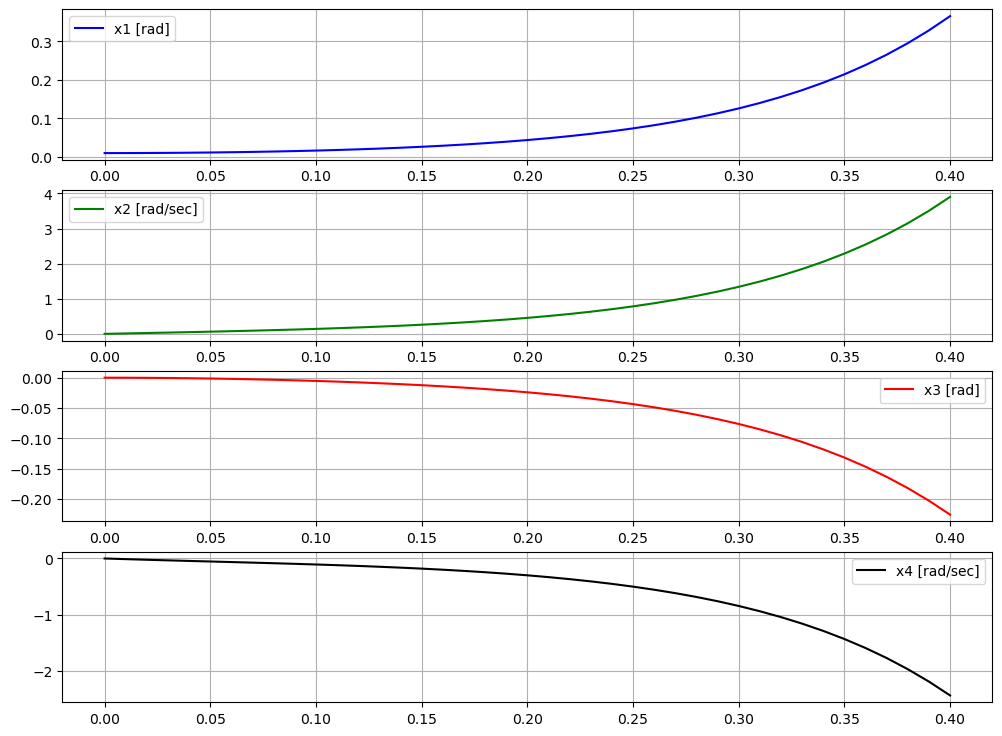

In [8]:
# Simulated data visualization 

x1 = yout[0, :]
x2 = yout[1, :]
x3 = yout[2, :]
x4 = yout[3, :]

plt.figure(1, figsize=(12, 9))

plt.subplot(4, 1, 1) 
plt.plot(t, x1, 'blue') 
plt.grid() 
plt.legend(labels=('x1 [rad]',))

plt.subplot(4, 1, 2) 
plt.plot(t, x2, 'green') 
plt.grid() 
plt.legend(labels=('x2 [rad/sec]',))

plt.subplot(4, 1, 3) 
plt.plot(t, x3, 'red') 
plt.grid() 
plt.legend(labels=('x3 [rad]',))

plt.subplot(4, 1, 4) 
plt.plot(t, x4, 'black') 
plt.grid() 
plt.legend(labels=('x4 [rad/sec]',))

# Exercises:
# Question: Why does this plot go to infinity?
# Try to play with initial state and control input using forced response

LQR Control

In [9]:
# Cost function parameters
Q = np.array([  [1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])
R = np.array([1])

# Solve the problem

# simple way
# K, sys, E = ct.dlqr(Ad, Bd, Q, R)

# solve by hands
# Solve discrete time algebraic Riccati equation (DARE)
sys = solve_discrete_are(Ad, Bd, Q, R)
# Calculate gains
K = np.linalg.inv(Bd.T @ sys @ Bd + R) @ (Bd.T @ sys @ Ad)

In [10]:
print("K Gains:")
print(K[0])

# Exercise:
# In the previous cell you can see the commented line 'K, sys, E = ct.dlqr(Ad, Bd, Q, R)'. The function dlqr does the same operations as you have done for getting K gains. Uncomment this line and compare the values of K matrix.

K Gains:
[-79.72349404  -7.06661661   0.79996803  -0.25687237]


Stability Analysis

In [ ]:
# The system is said to be asymptotically stable if all eigenvalues of the closed-loop matrix A_cl = A - BK
# lie strictly inside the unit circle in the complex plane

eigvals = np.linalg.eigvals(Ad - Bd @ K)
print("Eigenvalues of closed-loop system:", eigvals)
if np.all(np.abs(eigvals) < 1):
    print("System is asympthotically stable")
else:
    print("System is unstable")

Eigenvalues of closed-loop system: [0.75908269 0.99025055 0.89478346 0.8799163 ]
System is asympthotically stable


Closed-Loop System Simulation

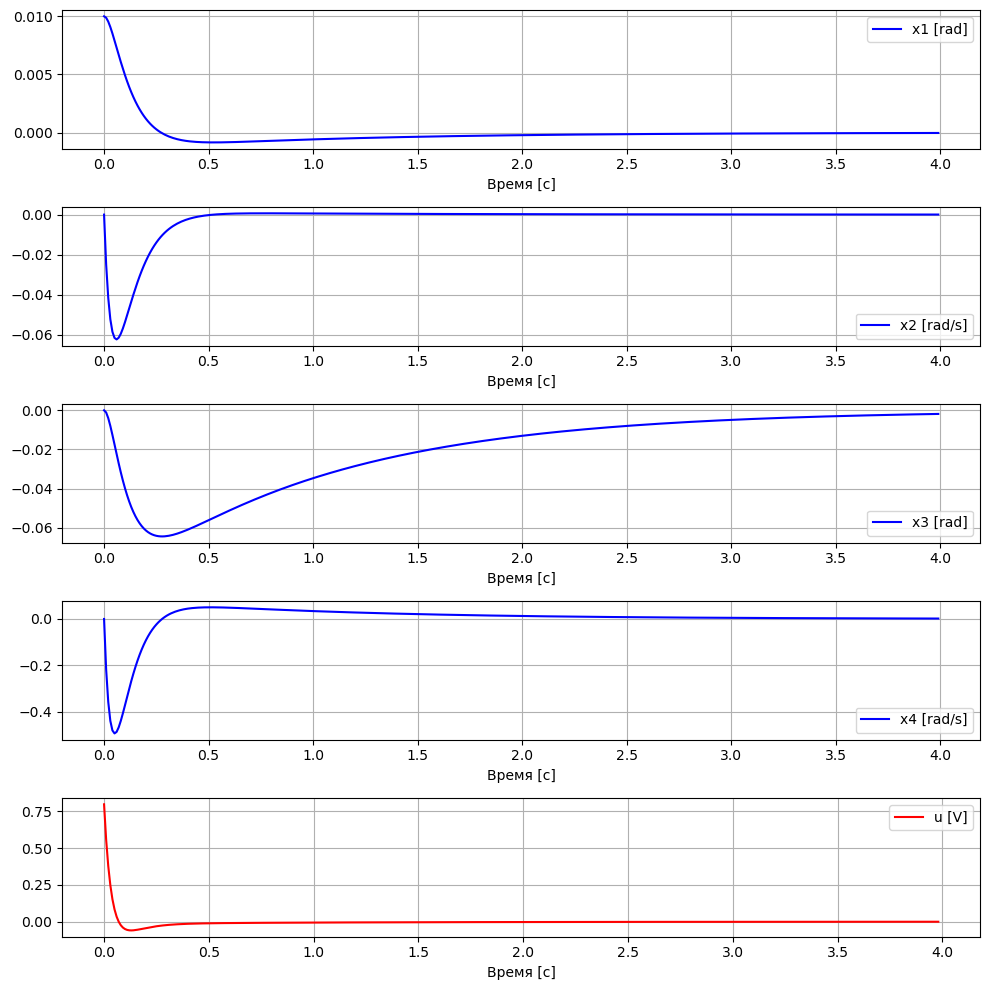

In [12]:
# State space model simulation

x0 = np.array([0.01, 0.0, 0.0, 0.0])  # начальное состояние (наклон маятника)
T = np.arange(0, 4, dt)
X = [x0]
U = []

for t in T[:-1]:
    u = -K @ X[-1]
    x_next = Ad @ X[-1] + Bd.flatten() * u
    X.append(x_next)
    U.append(u)

X = np.array(X)
U = np.array(U)
x1 = X[:, 0]
x2 = X[:, 1]
x3 = X[:, 2]
x4 = X[:, 3]

# Visualization

plt.figure(figsize=(10, 10))

plt.subplot(5, 1, 1) 
plt.plot(T, x1, 'blue') 
plt.grid() 
plt.legend(labels=('x1 [rad]',))
plt.xlabel("Время [с]")

plt.subplot(5, 1, 2) 
plt.plot(T, x2, 'blue') 
plt.grid() 
plt.legend(labels=('x2 [rad/s]',))
plt.xlabel("Время [с]")

plt.subplot(5, 1, 3) 
plt.plot(T, x3, 'blue') 
plt.grid() 
plt.legend(labels=('x3 [rad]',))
plt.xlabel("Время [с]")

plt.subplot(5, 1, 4) 
plt.plot(T, x4, 'blue') 
plt.grid() 
plt.legend(labels=('x4 [rad/s]',))
plt.xlabel("Время [с]")

plt.subplot(5, 1, 5) 
plt.plot(T[:-1], U, 'red') 
plt.grid() 
plt.legend(labels=('u [V]',))
plt.xlabel("Время [с]")

plt.tight_layout()
plt.show()

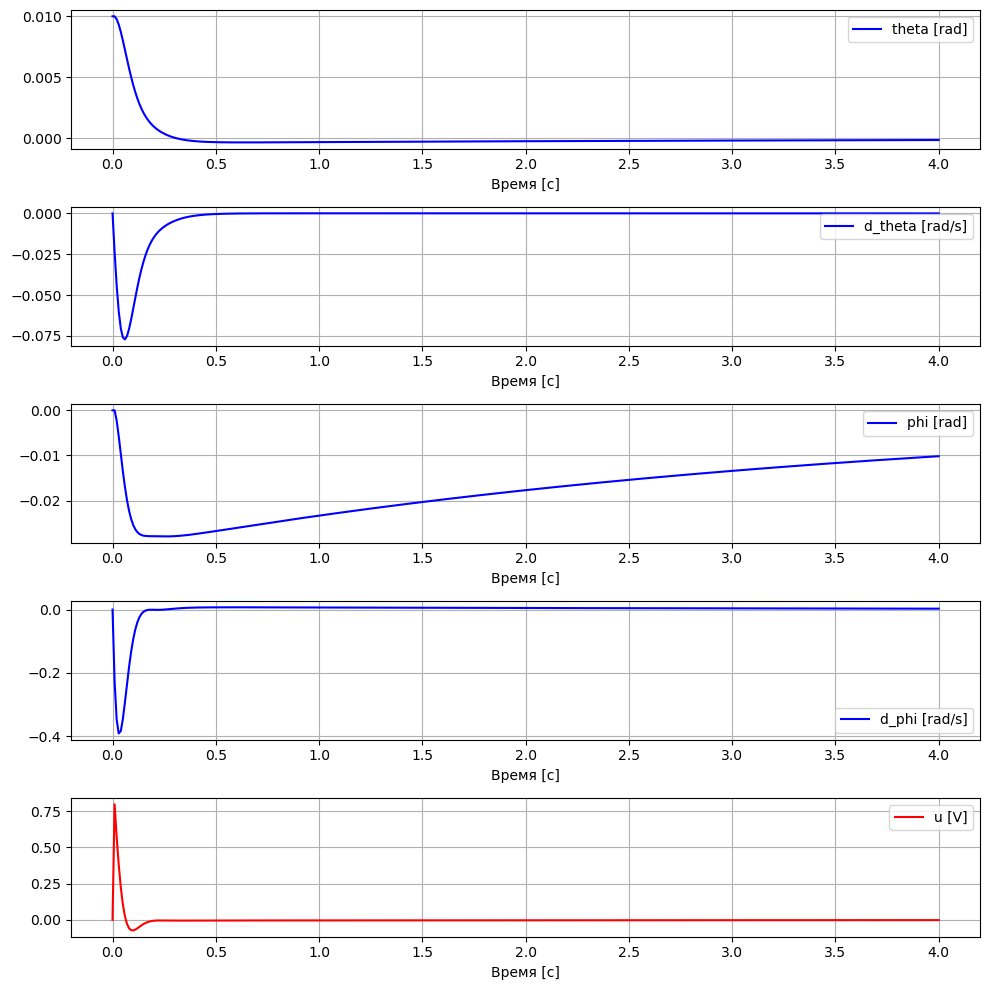

In [13]:
# Nonlinear model simulation

t0 = 0 # [s] 
t1 = 4.0 # [s] 

nt = int(t1/dt) + 1 # Number of points of sim time
T = np.linspace(t0, t1, nt)

x0 = np.array([0.01, 0.0, 0.0, 0.0]) #pend angle, pend angular vel, wheel speed
u = 0.0 # [V]

X = [x0]
U = [u]

x_cur = x0.copy()

for t in T[:-1]:
    u = -K @ x_cur
    u[0] = np.clip(u[0], -Vmax, Vmax)

    x_next = nonlinear_dynamics(x_cur[0], x_cur[1], x_cur[2], x_cur[3], u[0])

    X.append(x_next)
    U.append(u[0])

    x_cur = x_next.copy()

X = np.array(X)
U = np.array(U)
x1 = X[:, 0]
x2 = X[:, 1]
x3 = X[:, 2]
x4 = X[:, 3]

# Simulated data visualization 

plt.figure(figsize=(10, 10))

plt.subplot(5, 1, 1) 
plt.plot(T, x1, 'blue') 
plt.grid() 
plt.legend(labels=('theta [rad]',))
plt.xlabel("Время [с]")

plt.subplot(5, 1, 2) 
plt.plot(T, x2, 'blue') 
plt.grid() 
plt.legend(labels=('d_theta [rad/s]',))
plt.xlabel("Время [с]")

plt.subplot(5, 1, 3) 
plt.plot(T, x3, 'blue') 
plt.grid() 
plt.legend(labels=('phi [rad]',))
plt.xlabel("Время [с]")

plt.subplot(5, 1, 4) 
plt.plot(T, x4, 'blue') 
plt.grid() 
plt.legend(labels=('d_phi [rad/s]',))
plt.xlabel("Время [с]")

plt.subplot(5, 1, 5) 
plt.plot(T, U, 'red') 
plt.grid() 
plt.legend(labels=('u [V]',))
plt.xlabel("Время [с]")

plt.tight_layout()
plt.show()

# Exercise
# Play with the cost function coefficients and check how transient responce chenges its characteristics